# OpenCv

#### Обнаружение лица с помощью Haar Cascade в OpenCV

In [1]:
# Установка пакета OpenCv для Python.
# !pip install opencv-python

In [2]:
import cv2
from matplotlib import pyplot
import numpy as np

In [3]:
# Изображения
orig_di_caprio = cv2.imread('assets/di_caprio.jpg')
copy_di_caprio = orig_di_caprio.copy()
glasses = cv2.imread('assets/glasses3.png')

# Изображение очков 3-x канальное.
print(glasses.shape)

(1200, 1200, 3)


Каскады Хаара (Haar cascades) — это метод обнаружения объектов, основанный на распознавании характерных **паттернов (особенностей)** в изображении.

Этот метод **быстрый и лёгкий**, но точность оставляет желать лучшего.

### **Как работает алгоритм каскадов Хаара?**

1️ **Преобразование изображения в оттенки серого**
   - Так работать быстрее, ведь **цвет не важен** при поиске формы.

2 **Разделение изображения на маленькие участки**
   - Каскады Хаара анализируют **разные области** и ищут в них характерные паттерны (например, форму глаз, носа, рта).

3️ **Фильтры Хаара (Haar Features)**
   - Это **простые чёрно-белые маски**, которые помогают найти границы и контуры объектов.
   - Например, глаза обычно **темнее** области под бровями, а кончик носа **светлее** его окружения.
   - Каскадные фильтры ищут такие особенности.

4️ **Каскад классификаторов (Cascade Classifier)**
   - Это набор последовательных фильтров, которые постепенно **отбрасывают ненужные области**.
   - **Если на каком-то этапе область не похожа на лицо — она сразу исключается**.

5️ **Выход — найденные объекты**
   - В итоге алгоритм **возвращает координаты** областей, где нашёл лицо или другой объект.



### **Параметры `detectMultiScale`**
```python
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
```
`scaleFactor=1.1` — Увеличивает изображение на 10% на каждом этапе, чтобы найти лица разного размера.
`minNeighbors=5` — Чем выше значение, тем **жёстче фильтр** (меньше ложных срабатываний, но можно пропустить лица).
`minSize=(30,30)` — Минимальный размер объекта, который ищем.

---

### **Плюсы каскадов Хаара**
✅ Очень быстрый алгоритм

✅ Работает в реальном времени

✅ Не требует мощного железа

### **Минусы**
❌ Неустойчив к поворотам и ракурсам лица

❌ Легко даёт ложные срабатывания

❌ Работает хуже на сложных фонах

In [4]:
# Загрузка каскад Хаара.
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")


После того как мы получили координаты лица, определённые как:
- **x, y** – левый верхний угол объекта,
- **w, h** – ширина и высота.

### **1. Вырезаем область лица:**
```python
face = image[y:y + h, x:x + w]
```
Мы вырезаем найденную область лица.

**Почему указываем `y:y + h`?**
Допустим, `y = 1`, `h = 2`. Чтобы получить реальную границу области, нужно сложить `1 + 2 = 3`.
Так как координаты находятся в массиве, а срезы массива не включают последний элемент, мы получим диапазон `1, 2`, но не `3`.
То же самое работает и для `x`.

---

### **2. Определяем ширину области для очков:**
```python
sw = max(x1 + w1, x2 + w2) - sx
```
- Здесь мы ищем **максимальное значение ширины** из двух координат.
- Это значение указывает на правый глаз (смотря на изображение).
- sw — это ширина области, которая покрывает оба глаза

Почему применяем разность max(w) - sx:
- `sx = 2`, `w = 10`.
- Если просто взять `10`, мы выйдем за границы изображения.
- Чтобы получить **реальную ширину**, считаем: `sw = 10 - 2 = 8`.

---

### **3. Вырезаем область глаз с лица:**
```python
area_eyes = face[y_expanded:y_expanded + h_expanded, x_expanded:x_expanded + w_expanded]
```
Выделяем область глаз, куда будем вставлять очки.

---

### **4. Изменяем размер очков под область глаз:**
```python
mask_glasses = cv2.resize(glasses, (w_expanded, h_expanded), interpolation=cv2.INTER_AREA)
```
Метод **`cv2.INTER_AREA`** подходит для уменьшения изображения, так как усредняет соседние пиксели.

Принцип работы:
Если есть два пикселя:
- `пиксель1 = [r1, g1, b1]`
- `пиксель2 = [r2, g2, b2]`
То новый пиксель рассчитывается как:
- `(r1 + r2) / 2, (g1 + g2) / 2, (b1 + b2) / 2`.

То, есть одинаковые каналы пикселей усредняются.

---

### **5. Преобразуем очки в оттенки серого:**
```python
gray_mask = cv2.cvtColor(mask_glasses, cv2.COLOR_BGR2GRAY)
```
Очки изначально **трёхканальные** (RGB), поэтому переводим их в **одноцветное изображение (оттенки серого)**.

---

### **6. Создаём маску для выделения очков:**
```python
_, mask = cv2.threshold(gray_mask, 50, 255, cv2.THRESH_BINARY_INV)
```
Этот метод проходит по пикселям и изменяет их:
- **Светлые пиксели (`> 50`) становятся чёрными (0)**.
- **Тёмные (`<= 50`) – белыми (255)**.

Так мы получаем **маску очков**:
- **Очки белые**.
- **Фон чёрный**.

---

### **7. Создаём маску для фона (инверсия маски очков):**
```python
mask_inv = cv2.bitwise_not(mask)
```
- Теперь **фон становится белым**, а **очки – чёрными**.
- Эта маска нужна для правильного наложения очков на лицо.

---

### **8. Применяем маску к изображению очков:**
```python
masked_mouth = cv2.bitwise_and(mask_glasses, mask_glasses, mask=mask)
```
- **bitwise_and** сравнивает пиксели двух изображений (в данном случае одно и то же изображение).
- Маска работает как **трафарет**:
  - Белая область остаётся **нетронутой**.
  - Чёрная область **становится чёрной**.

Теперь мы имеем изображение с очками **на чёрном фоне**. Хотелось бы еще раз отметить, что очки никуда не делись.

---

### **9. Применяем маску фона на лицо:**
```python
masked_face = cv2.bitwise_and(area_eyes, area_eyes, mask=mask_inv)
```
- Здесь маска **инвертирована**:
  - **Белый фон** остаётся **нетронутым**.
  - **Чёрные пиксели (место очков)** становятся **чёрными**.

Это создаёт "пустую" область, куда мы будем вставлять очки.

---

### **10. Складываем изображения лица и очков:**
```python
face[y_expanded:y_expanded + h_expanded, x_expanded:x_expanded + w_expanded] = cv2.add(masked_mouth, masked_face)
```
Что здесь происходит?
- **masked_mouth** – изображение очков на чёрном фоне.
- **masked_face** – лицо, где вырезана область под очки.
- `cv2.add()` **суммирует пиксели**:
  - В местах чёрных пикселей подставляется изображение очков.
  - Остальная часть лица остаётся неизменной.
  - Чёрный фон ни на что не влияет, так как 0 + X = X. 0 - черный пиксель, X - значение другого пикселя.
  - Если сложить masked_face + masked_face, то фон осветлиться, поэтому нужен промежуточный шаг очернить фон у очков и наложить ИЗОБРАЖЕНИЕ очков, а не нарисовать черную область в виде очков, чтобы сохранить естественность цвета лица.

In [5]:
def draw_face_and_glasses(image, classifier_face, classifier_eye, glasses):
    faces = classifier_face.detectMultiScale(image, scaleFactor=1.3, minNeighbors=3, minSize=(50, 50))

    if len(faces) == 0:
        return image # Если лицо не найдено, возвращаем исходное изображение


    x, y, w, h = faces[0]
    center = (int(x + 0.5 * w), int(y + 0.5 * h))
    radius = int(0.6 * h)
    color = (0, 255, 0)
    cv2.circle(image, center, radius, color, 2)

    # Вырезаем найденную область лица
    face = image[y:y + h, x:x + w]
    #  Определяем глаза в области лица
    eyes = classifier_eye.detectMultiScale(face)

    if len(eyes) >= 2:
        # Берём 2 массива(глаза из img), которые хранят координаты.
        (x1, y1, w1, h1), (x2, y2, w2, h2) = eyes[:2]

        # Определяем границы для очков.
        # То, есть выделяем прямоугольником оба глаза, чтобы вписать туда очки
        # Ориентиры описаны смотря на лицо
        sx, sy = min(x1, x2), min(y1, y2) # Левый верхний угол левого глаза
        # Ищем наибольшие значения ширины и высоты, чтобы найти правый нижний угол правого глаза
        sw = max(x1 + w1, x2 + w2) - sx
        sh = max(y1 + h1, y2 + h2) - sy

        # Расширение области очков. Подгоняем координаты для симметрии.
        x_expanded = max(0, sx - int(0.15 * sw))
        y_expanded = max(0, sy - int(0.6 * sh))
        w_expanded = int(sw * 1.34)
        h_expanded = int(sh * 3)

        # Срезаем область глаз и изменяем размер очков
        area_eyes = face[y_expanded:y_expanded + h_expanded, x_expanded:x_expanded + w_expanded]
        mask_glasses = cv2.resize(glasses, (w_expanded, h_expanded), interpolation=cv2.INTER_AREA)

        # Черно-белая маска очков
        gray_mask = cv2.cvtColor(mask_glasses, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_mask, 50, 255, cv2.THRESH_BINARY_INV)
        mask_inv = cv2.bitwise_not(mask)

        # Применение маски для глаз и очков
        # Устраняем шум вокруг очков, делая фон чёрным. (Очки остаются как изображение, а не сливаются с фоном)
        masked_mouth = cv2.bitwise_and(mask_glasses, mask_glasses, mask=mask)
        # Закрашиваем чёрным область под очки.
        masked_face = cv2.bitwise_and(area_eyes, area_eyes, mask=mask_inv)

        # Наложение очков на лицо
        face[y_expanded:y_expanded + h_expanded, x_expanded:x_expanded + w_expanded] = cv2.add(masked_mouth,
                                                                                               masked_face)

    return image


result = draw_face_and_glasses(copy_di_caprio, classifier_face, classifier_eye, glasses)

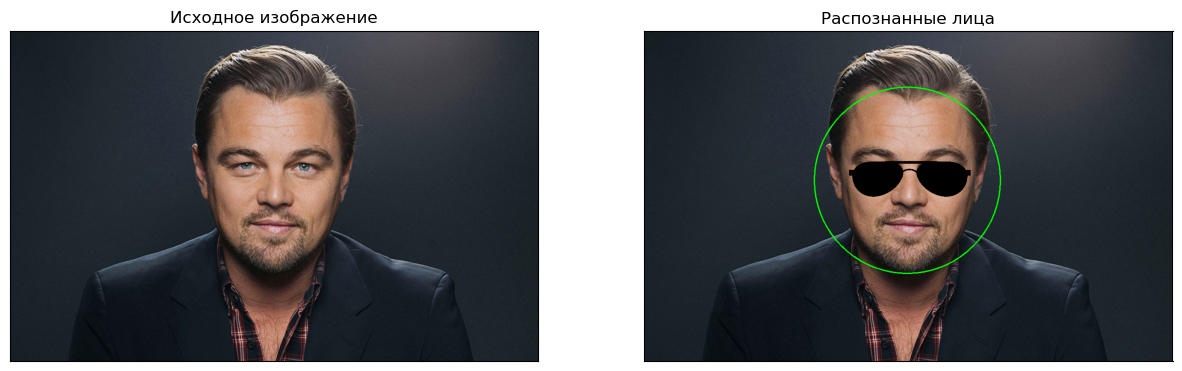

In [6]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(orig_di_caprio, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(copy_di_caprio, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Распознанные лица')

pyplot.show()

In [7]:
# Функция размытия
def blur_face(img):
    (h, w) = img.shape[:2]
    dW = int(w / 3.0)
    dH = int(h / 3.0)
    if dW % 2 == 0:
        dW -= 1
    if dH % 2 == 0:
        dH -= 1
    return cv2.GaussianBlur(img, (dW, dH), 0)


def apply_face_blur(image, classifier_face, classifier_eye):
    # Детектирование лиц
    faces = classifier_face.detectMultiScale(image, scaleFactor=1.3, minNeighbors=3, minSize=(50, 50))

    if len(faces) == 0:
        return image  # Если лицо не найдено, возвращаем исходное изображение

    # Координаты найденного лица
    x, y, w, h = faces[0]
    # Обрезаем лицо
    orig_face = image[y:y + h, x:x + w]

    # Детектирование глаз
    eyes = classifier_eye.detectMultiScale(orig_face)

    # Применение размытия к лицу
    face_mask = orig_face.copy()
    blured_face = blur_face(orig_face)

    # Размытие области лица
    image[y:y + h, x:x + w] = blured_face

    if len(eyes) >= 2:
        # Берём 2 массива(глаза из img), которые хранят координаты.
        (x1, y1, w1, h1), (x2, y2, w2, h2) = eyes[:2]
        sx, sy = min(x1, x2), min(y1, y2)
        sw = max(x1 + w1, x2 + w2) - sx
        sh = max(y1 + h1, y2 + h2) - sy
        # Область глаз
        eye_roi = face_mask[sy:sy + sh, sx:sx + sw]
        orig_face[sy:sy + sh, sx:sx + sw] = eye_roi

    # # Восстановление глаз по отдельности
    # for (ex, ey, ew, eh) in eyes:
    #     eye_roi = face_mask[ey:ey + eh, ex:ex + ew]
    #     orig_face[ey:ey + eh, ex:ex + ew] = eye_roi

    return image


apply_face_blur(orig_di_caprio, classifier_face, classifier_eye)

array([[[35, 29, 22],
        [32, 26, 19],
        [32, 26, 19],
        ...,
        [54, 47, 38],
        [51, 44, 35],
        [48, 41, 32]],

       [[35, 29, 22],
        [32, 26, 19],
        [32, 26, 19],
        ...,
        [53, 46, 37],
        [51, 44, 35],
        [50, 43, 34]],

       [[35, 29, 22],
        [33, 27, 20],
        [33, 27, 20],
        ...,
        [52, 45, 36],
        [52, 45, 36],
        [51, 44, 35]],

       ...,

       [[37, 30, 21],
        [37, 30, 21],
        [37, 30, 21],
        ...,
        [40, 34, 29],
        [40, 36, 31],
        [38, 34, 29]],

       [[37, 30, 21],
        [37, 30, 21],
        [37, 30, 21],
        ...,
        [40, 34, 29],
        [40, 36, 31],
        [38, 34, 29]],

       [[40, 33, 24],
        [40, 33, 24],
        [40, 33, 24],
        ...,
        [39, 33, 26],
        [39, 36, 28],
        [40, 37, 29]]], dtype=uint8)

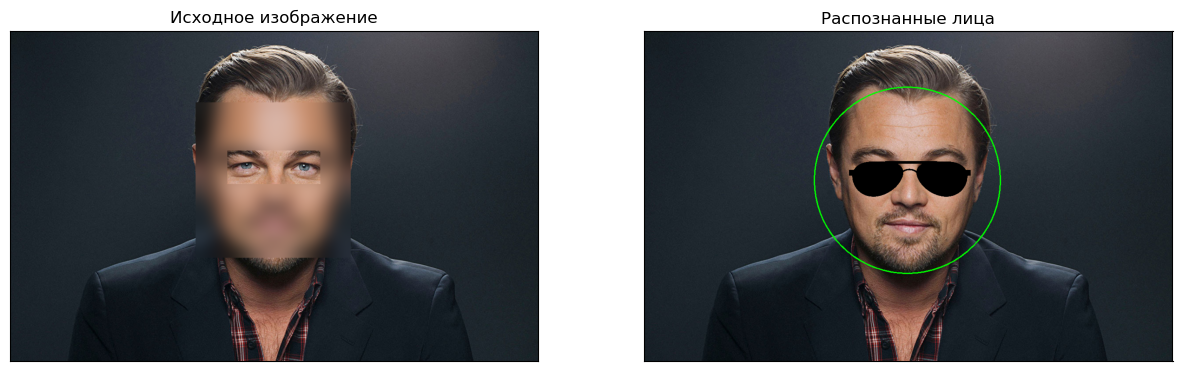

In [8]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(orig_di_caprio, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(copy_di_caprio, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Распознанные лица')

pyplot.show()

#### В заключение хотелось бы сказать, что каскады Хаара — отличный вариант для простых задач, благодаря своей скорости и эффективности. Однако, для более сложных проектов, лучше использовать нейросети, такие, как YOLO, MTCNN или SSD.